In [1]:
import os

import pandas as pd
from time import time
from joblib import load, dump

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import SGDClassifier, SGDRegressor, Ridge, LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, r2_score, mean_squared_error, mean_absolute_error

In [3]:
from fire_modules import severity_matrix as sm

In [4]:
seed = 42

In [5]:
csv_path = os.path.join('data', 'fires_transformed.csv')
df = pd.read_csv(csv_path)
df.sample(5, random_state=seed)

,elevacion,erodi,slope,orientacion_sen,orientacion_cos,altura,lfcc,inflam,mcroth,anomalia,dpv,vel_media_viento,severidad_real,severidad_discreta,coord_x_etrs89,coord_y_etrs89,incendio,provincia
119340,1024.904053,4,15.177,0.994650,0.103298,9.0,46.956501,3,2,73.561211,2.246882,2.916394,0.845614,3,490110.0,4538190.0,Cogolludo,Guadalajara
58023,505.352997,1,25.718,0.206331,0.978482,3.0,19.892401,4,3,86.961823,2.385298,4.876472,0.270908,1,604950.0,4257480.0,Talave,Albacete
46997,388.710999,2,31.593,-0.984000,0.178167,1.0,0.956900,4,3,79.168137,2.319516,5.026659,0.412787,1,617730.0,4243860.0,Donceles,Albacete
67214,1063.177002,1,22.364,0.901304,-0.433188,2.0,7.424201,4,1,50.321835,0.349119,2.470344,0.576249,2,561090.0,4256790.0,Yeste,Albacete
153590,507.516998,3,13.911,0.872081,0.489362,3.0,32.275799,4,3,72.893860,1.469779,3.393716,0.310006,1,407340.0,4412550.0,Montesion,Toledo


In [6]:
numerical_variables = ['elevacion', 'slope', 'orientacion_sen', 'orientacion_cos', 'altura', 'lfcc', 'anomalia', 'dpv', 'vel_media_viento']
categorical_variables = ['erodi', 'inflam', 'mcroth']
variables = numerical_variables + categorical_variables
target_real = 'severidad_real'
target_discrete = 'severidad_discreta'

coords_columns = ['coord_x_etrs89', 'coord_y_etrs89']

In [7]:
fire_names = list(df['incendio'].unique())
test_fire_names = ['Agramon', 'Almansa', 'Malagon', 'La_Iglesuela']
train_fire_names = [x for x in fire_names if x not in test_fire_names]

print(f'Train: {train_fire_names}')
print(f'Test:  {test_fire_names}')

Train: ['Donceles', 'Lietor', 'Talave', 'Yeste', 'Cañada_del_Hoyo', 'Bustares', 'Cogolludo', 'Almorox', 'Cadalso', 'Montesion', 'Villanueva_de_Bogas']
Test:  ['Agramon', 'Almansa', 'Malagon', 'La_Iglesuela']


In [8]:
df_train = df[df['incendio'].isin(train_fire_names)].reset_index(drop=True)
print(len(df_train))
df_train.head()

133092


,elevacion,erodi,slope,orientacion_sen,orientacion_cos,altura,lfcc,inflam,mcroth,anomalia,dpv,vel_media_viento,severidad_real,severidad_discreta,coord_x_etrs89,coord_y_etrs89,incendio,provincia
0,474.993988,1,2.988,0.591536,0.806278,4.0,13.578500,4,3,78.942978,2.530710,5.199876,0.153908,0,607110.0,4256310.0,Donceles,Albacete
1,472.980011,1,2.177,0.997200,0.074776,8.0,10.838201,4,3,78.941406,2.531341,5.200114,0.174595,0,607140.0,4256310.0,Donceles,Albacete
2,466.144989,1,7.510,0.977572,-0.210601,9.0,17.604599,4,3,78.936714,2.533220,5.200821,0.176796,0,607230.0,4256310.0,Donceles,Albacete
3,475.859985,1,3.765,0.762302,0.647222,4.0,14.039700,4,3,78.944611,2.529883,5.199497,0.168421,0,607110.0,4256280.0,Donceles,Albacete
4,473.007996,1,3.792,0.986111,0.166089,4.0,16.137899,4,3,78.943054,2.530514,5.199735,0.202057,0,607140.0,4256280.0,Donceles,Albacete


In [9]:
df_test = df[df['incendio'].isin(test_fire_names)].reset_index(drop=True)
print(len(df_test))
df_test.head()

24441


,elevacion,erodi,slope,orientacion_sen,orientacion_cos,altura,lfcc,inflam,mcroth,anomalia,dpv,vel_media_viento,severidad_real,severidad_discreta,coord_x_etrs89,coord_y_etrs89,incendio,provincia
0,482.423004,1,15.401000,0.091827,0.995775,10.0,13.2000,3,3,80.210800,1.464469,2.855457,0.155662,0,615180.0,4257300.0,Agramon,Albacete
1,487.563995,1,20.632999,0.087687,0.996148,1.0,0.7326,3,3,80.228157,1.463829,2.855017,0.224380,0,614850.0,4257270.0,Agramon,Albacete
2,486.273987,1,12.380000,-0.129868,0.991531,1.0,5.1383,3,3,80.207359,1.464057,2.855563,0.308407,1,615120.0,4257270.0,Agramon,Albacete
3,495.325989,1,21.625000,0.222399,0.974956,1.0,1.4184,3,3,80.210716,1.463563,2.855489,0.207618,0,614970.0,4257240.0,Agramon,Albacete
4,490.188995,1,19.408001,-0.010958,0.999940,4.0,7.4510,3,3,80.206093,1.463614,2.855611,0.292563,1,615030.0,4257240.0,Agramon,Albacete


In [10]:
folds = []

for name in train_fire_names:
    fold_train_names = [x for x in train_fire_names if x != name]
    fold_test_name = [x for x in train_fire_names if x == name]

    fold_train_indices = df_train[df_train['incendio'].isin(fold_train_names)].index
    fold_test_indices = df_train[df_train['incendio'].isin(fold_test_name)].index
    folds.append((fold_train_indices, fold_test_indices))

[print(f'Fold {i}: Train: {x.size}\tTest:{y.size}') for i, (x, y) in enumerate(folds)];

Fold 0: Train: 89881	Test:43211
Fold 1: Train: 126960	Test:6132
Fold 2: Train: 124441	Test:8651
Fold 3: Train: 106022	Test:27070
Fold 4: Train: 130108	Test:2984
Fold 5: Train: 130127	Test:2965
Fold 6: Train: 117139	Test:15953
Fold 7: Train: 122027	Test:11065
Fold 8: Train: 126495	Test:6597
Fold 9: Train: 125318	Test:7774
Fold 10: Train: 132402	Test:690


In [11]:
def optimize_params(estimator, X, y, cv, scoring=None, refit=True, **param_grid):
    t = time()
    # GridSearch over specified parameter values for an estimator
    grid_search_cv = GridSearchCV(estimator,
                                  param_grid,
                                  scoring=scoring,
                                  refit=False,  # Disable automatic refit to manually select best estimator
                                  cv=cv,
                                  verbose=1,
                                  n_jobs=10,
                                  return_train_score=True).fit(X, y)

    cv_results = pd.DataFrame(grid_search_cv.cv_results_)   

    # Calculate weighted sizes of each fold
    sizes_train = []
    sizes_test = []
    for train_indexes, test_indexes in cv:
        sizes_train.append(len(train_indexes))
        sizes_test.append(len(test_indexes))
    total_sizes_train = sum(sizes_train)
    total_sizes_test = sum(sizes_test)
    weighted_sizes_train = [x / total_sizes_train for x in sizes_train]
    weighted_sizes_test = [x / total_sizes_test for x in sizes_test]

    # Calculate weighted mean score for train and test
    weighted_mean_train_score = sum(cv_results[f'split{i}_train_score'] * weighted_sizes_train[i] for i in range(len(weighted_sizes_train)))
    cv_results.insert(cv_results.columns.get_loc('mean_train_score'), 'weighted_mean_train_score', weighted_mean_train_score)
    weighted_mean_test_score = sum(cv_results[f'split{i}_test_score'] * weighted_sizes_test[i] for i in range(len(weighted_sizes_test)))
    cv_results.insert(cv_results.columns.get_loc('mean_test_score'), 'weighted_mean_test_score', weighted_mean_test_score)

    # Order params by the weighted mean test score
    cv_results = cv_results.sort_values(by='weighted_mean_test_score', ascending=False)
    cv_results['rank_test_score'] = range(1, len(cv_results) + 1)

    # Drop the results for each validation split
    labels = cv_results.filter(regex="split")
    cv_results = cv_results.drop(labels, axis=1)

    print(f'Time: {round(time()-t, 2)} seg.')
    display(cv_results)

    grid_search_cv.best_index_ = cv_results.index[0]
    grid_search_cv.best_params_ = cv_results.loc[grid_search_cv.best_index_, 'params']
    grid_search_cv.best_score_ = cv_results.loc[grid_search_cv.best_index_, 'weighted_mean_test_score']
    # Refit with best params
    if refit:
        grid_search_cv.best_estimator_ = grid_search_cv.estimator.set_params(**grid_search_cv.best_params_).fit(X, y)
    
    return grid_search_cv

In [12]:
preprocessing = make_column_transformer(
        (StandardScaler(), numerical_variables),
        (OneHotEncoder(handle_unknown='ignore'), categorical_variables),
        remainder='passthrough'
)

# Regresión

In [13]:
X_train = df_train[variables]
y_train = df_train[target_real]

X_test = df_test[variables]
y_test = df_test[target_real]

## Grid Search

### Linear Regression

In [14]:
poly = PolynomialFeatures(include_bias=False)
linear_reg = Ridge(random_state=seed)
linear_reg_pipeline = make_pipeline(preprocessing, poly, linear_reg)

param_grid = {
    'polynomialfeatures__degree': [1, 2, 3],
    'ridge__alpha': [0.01, 0.1, 0.5, 1, 2, 10]
}

linear_reg_gs = optimize_params(linear_reg_pipeline, X_train, y_train, folds, scoring='r2', **param_grid)

Fitting 11 folds for each of 18 candidates, totalling 198 fits
Time: 945.62 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures__degree,param_ridge__alpha,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
5,0.330862,0.036431,0.025630,0.018580,1,10,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.184516,-0.331029,3.655700e-01,1,0.156861,0.157365,0.020174
4,0.325139,0.034219,0.024614,0.020139,1,2,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.185217,-0.331778,3.663059e-01,2,0.156861,0.157365,0.020174
3,0.323928,0.031320,0.027931,0.017401,1,1,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.185306,-0.331872,3.663987e-01,3,0.156861,0.157366,0.020174
2,0.326184,0.030623,0.023515,0.016716,1,0.5,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.185350,-0.331919,3.664452e-01,4,0.156861,0.157366,0.020174
1,0.315089,0.032638,0.023036,0.019771,1,0.1,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.185386,-0.331957,3.664824e-01,5,0.156861,0.157366,0.020174
0,0.336280,0.035926,0.018756,0.018122,1,0.01,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.185394,-0.331966,3.664908e-01,6,0.156861,0.157366,0.020174
11,1.883842,0.196820,0.089118,0.081669,2,10,"{'polynomialfeatures__degree': 2, 'ridge__alph...",-101.079899,-52.913548,1.253194e+02,7,0.306967,0.307226,0.011470
10,1.904454,0.198766,0.093019,0.084635,2,2,"{'polynomialfeatures__degree': 2, 'ridge__alph...",-179.496468,-98.790726,2.063769e+02,8,0.307960,0.308220,0.011448
9,1.874981,0.221614,0.089018,0.080367,2,1,"{'polynomialfeatures__degree': 2, 'ridge__alph...",-202.336187,-114.878110,2.302879e+02,9,0.308134,0.308397,0.011440
8,1.761679,0.171967,0.086248,0.077475,2,0.5,"{'polynomialfeatures__degree': 2, 'ridge__alph...",-215.894301,-126.094588,2.456076e+02,10,0.308227,0.308494,0.011429


### KNeighbors

In [15]:
k_neighbors_reg = KNeighborsRegressor()
k_neighbours_reg_pipeline = make_pipeline(preprocessing, k_neighbors_reg)

param_grid = {
    'kneighborsregressor__n_neighbors': [5, 10, 20, 50, 100],
    'kneighborsregressor__weights': ['uniform', 'distance']
}

k_neighbors_reg_gs = optimize_params(k_neighbours_reg_pipeline, X_train, y_train, folds, scoring='r2', **param_grid)

Fitting 11 folds for each of 10 candidates, totalling 110 fits
Time: 1828.45 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsregressor__n_neighbors,param_kneighborsregressor__weights,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
8,0.101939,0.011688,14.284606,12.217736,100,uniform,"{'kneighborsregressor__n_neighbors': 100, 'kne...",-0.110441,-0.159069,0.126268,1,0.380962,0.381022,1.077334e-02
9,0.109445,0.007463,14.225893,11.881054,100,distance,"{'kneighborsregressor__n_neighbors': 100, 'kne...",-0.111175,-0.159410,0.126305,2,1.000000,1.000000,7.720073e-13
6,0.097512,0.011025,13.476723,11.198015,50,uniform,"{'kneighborsregressor__n_neighbors': 50, 'knei...",-0.134202,-0.182516,0.131915,3,0.411022,0.411119,1.068848e-02
7,0.097935,0.014225,13.503472,11.398713,50,distance,"{'kneighborsregressor__n_neighbors': 50, 'knei...",-0.135109,-0.183305,0.132272,4,1.000000,1.000000,2.763351e-13
4,0.093840,0.007960,13.253373,11.057077,20,uniform,"{'kneighborsregressor__n_neighbors': 20, 'knei...",-0.186804,-0.244810,0.151552,5,0.458812,0.458949,1.058770e-02
5,0.093299,0.011881,13.233546,11.053517,20,distance,"{'kneighborsregressor__n_neighbors': 20, 'knei...",-0.187623,-0.245781,0.152224,6,1.000000,1.000000,6.926519e-14
2,0.094035,0.008968,13.048742,10.695109,10,uniform,"{'kneighborsregressor__n_neighbors': 10, 'knei...",-0.248880,-0.318376,0.187931,7,0.506107,0.506272,1.003859e-02
3,0.102326,0.004923,13.447916,11.407825,10,distance,"{'kneighborsregressor__n_neighbors': 10, 'knei...",-0.249242,-0.318809,0.188486,8,1.000000,1.000000,2.297542e-14
0,0.137830,0.036085,13.623679,10.971708,5,uniform,"{'kneighborsregressor__n_neighbors': 5, 'kneig...",-0.332158,-0.419033,0.232030,9,0.575707,0.575848,9.095723e-03
1,0.094808,0.015011,13.113551,10.870658,5,distance,"{'kneighborsregressor__n_neighbors': 5, 'kneig...",-0.332426,-0.419577,0.232390,10,1.000000,1.000000,7.975432e-15


### Decision Tree

In [16]:
decision_tree_reg = DecisionTreeRegressor(random_state=seed)
decision_tree_reg_pipeline = make_pipeline(preprocessing, decision_tree_reg)

param_grid = {
    'decisiontreeregressor__max_depth': [3, 5, 7, 10, None],
    'decisiontreeregressor__min_samples_split': [2, 50, 200],
    'decisiontreeregressor__criterion': ['squared_error', 'friedman_mse', 'poisson'],
    'decisiontreeregressor__ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.1]
}

decision_tree_reg_gs = optimize_params(decision_tree_reg_pipeline, X_train, y_train, folds, scoring='r2', **param_grid)

Fitting 11 folds for each of 225 candidates, totalling 2475 fits
Time: 2991.04 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeregressor__ccp_alpha,param_decisiontreeregressor__criterion,param_decisiontreeregressor__max_depth,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
224,5.953313,0.713240,0.012390,0.009356,0.1,poisson,None,"{'decisiontreeregressor__ccp_alpha': 0.1, 'dec...",-0.161746,-0.420109,0.566279,1,-1.066963e-17,-1.009294e-17,1.105626e-16
182,1.379514,0.136792,0.012762,0.007343,0.1,squared_error,3,"{'decisiontreeregressor__ccp_alpha': 0.1, 'dec...",-0.161746,-0.420109,0.566279,2,-1.066963e-17,-1.009294e-17,1.105626e-16
160,3.937646,0.421126,0.011871,0.005871,0.01,friedman_mse,10,"{'decisiontreeregressor__ccp_alpha': 0.01, 'de...",-0.161746,-0.420109,0.566279,3,-1.066963e-17,-1.009294e-17,1.105626e-16
161,3.891389,0.387128,0.012056,0.006079,0.01,friedman_mse,10,"{'decisiontreeregressor__ccp_alpha': 0.01, 'de...",-0.161746,-0.420109,0.566279,4,-1.066963e-17,-1.009294e-17,1.105626e-16
162,162.689009,28.367206,0.016913,0.011101,0.01,friedman_mse,None,"{'decisiontreeregressor__ccp_alpha': 0.01, 'de...",-0.161746,-0.420109,0.566279,5,-1.066963e-17,-1.009294e-17,1.105626e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,6.088771,0.631195,0.011277,0.005515,0,friedman_mse,None,"{'decisiontreeregressor__ccp_alpha': 0, 'decis...",-0.746423,-1.077474,0.853512,221,7.533695e-01,7.533946e-01,1.402068e-02
13,6.187394,0.790454,0.011378,0.005350,0,squared_error,None,"{'decisiontreeregressor__ccp_alpha': 0, 'decis...",-0.749877,-1.077919,0.851297,222,7.533695e-01,7.533946e-01,1.402068e-02
12,8.557828,0.917278,0.012145,0.006336,0,squared_error,None,"{'decisiontreeregressor__ccp_alpha': 0, 'decis...",-1.422791,-1.900763,0.952741,223,1.000000e+00,1.000000e+00,0.000000e+00
42,9.655411,0.976254,0.011907,0.004635,0,poisson,None,"{'decisiontreeregressor__ccp_alpha': 0, 'decis...",-1.434176,-1.775086,0.728557,224,1.000000e+00,1.000000e+00,0.000000e+00


### Random Forest

In [17]:
random_forest_reg = RandomForestRegressor(random_state=seed)
random_forest_reg_pipeline = make_pipeline(preprocessing, random_forest_reg)

param_grid = {
    'randomforestregressor__n_estimators': [10, 25, 50],
    'randomforestregressor__max_depth': [3, 5, 7, 10, None]
}

random_forest_reg_gs = optimize_params(random_forest_reg_pipeline, X_train, y_train, folds, scoring='r2', **param_grid)

Fitting 11 folds for each of 15 candidates, totalling 165 fits
Time: 1404.85 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
4,38.762836,3.847326,0.023507,0.015072,5,25,"{'randomforestregressor__max_depth': 5, 'rando...",-0.125075,-0.335748,0.518643,1,0.269271,0.270006,0.020700
7,53.264141,5.350029,0.024745,0.017658,7,25,"{'randomforestregressor__max_depth': 7, 'rando...",-0.126740,-0.316797,0.365351,2,0.367310,0.367892,0.031073
5,77.218890,7.736968,0.033536,0.024061,5,50,"{'randomforestregressor__max_depth': 5, 'rando...",-0.127818,-0.331270,0.503955,3,0.272423,0.273046,0.019173
8,106.485646,10.243065,0.038139,0.033027,7,50,"{'randomforestregressor__max_depth': 7, 'rando...",-0.135019,-0.345327,0.415134,4,0.371116,0.371549,0.029575
1,23.648204,2.374856,0.021019,0.013538,3,25,"{'randomforestregressor__max_depth': 3, 'rando...",-0.135140,-0.283375,0.431756,5,0.174551,0.175378,0.017294
3,15.769614,1.526276,0.017099,0.009460,5,10,"{'randomforestregressor__max_depth': 5, 'rando...",-0.135971,-0.353485,0.526872,6,0.268491,0.268664,0.021419
2,46.997475,4.693438,0.028388,0.019451,3,50,"{'randomforestregressor__max_depth': 3, 'rando...",-0.137104,-0.285537,0.431742,7,0.176019,0.176792,0.016438
0,9.715238,0.973251,0.016769,0.008882,3,10,"{'randomforestregressor__max_depth': 3, 'rando...",-0.140084,-0.289302,0.431164,8,0.174517,0.175027,0.017149
6,21.467602,2.108057,0.017013,0.011555,7,10,"{'randomforestregressor__max_depth': 7, 'rando...",-0.163255,-0.362855,0.418287,9,0.365237,0.365077,0.031193
11,148.233625,14.532540,0.047503,0.040181,10,50,"{'randomforestregressor__max_depth': 10, 'rand...",-0.215153,-0.405530,0.379095,10,0.543091,0.543526,0.021176


### XGBoost

In [18]:
xgb_reg = XGBRegressor(random_state=seed)
xgb_reg_pipeline = make_pipeline(preprocessing, xgb_reg)

param_grid = {
    'xgbregressor__n_estimators': [10, 25, 50, 100],
    'xgbregressor__max_depth': [3, 5, 7, 10, None],
    'xgbregressor__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
}

xgb_reg_gs = optimize_params(xgb_reg_pipeline, X_train, y_train, folds, scoring='r2', **param_grid)

Fitting 11 folds for each of 120 candidates, totalling 1320 fits
Time: 308.93 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__learning_rate,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
59,2.710910,0.249947,0.061540,0.053091,0.01,None,100,"{'xgbregressor__learning_rate': 0.01, 'xgbregr...",-0.080841,-0.235094,0.335650,1,0.322112,0.322640,0.011529
51,3.398135,0.266175,0.072318,0.063516,0.01,7,100,"{'xgbregressor__learning_rate': 0.01, 'xgbregr...",-0.081463,-0.243791,0.332916,2,0.359791,0.359858,0.011817
77,1.130071,0.110601,0.033142,0.020529,0.05,None,25,"{'xgbregressor__learning_rate': 0.05, 'xgbregr...",-0.081759,-0.217347,0.310795,3,0.361344,0.361906,0.013432
76,0.822825,0.090350,0.026050,0.013539,0.05,None,10,"{'xgbregressor__learning_rate': 0.05, 'xgbregr...",-0.083491,-0.280110,0.437872,4,0.215826,0.215917,0.006279
116,0.818654,0.106783,0.022968,0.013539,0.2,None,10,"{'xgbregressor__learning_rate': 0.2, 'xgbregre...",-0.083638,-0.196913,0.299035,5,0.428365,0.429193,0.019674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,6.038988,0.319246,0.118023,0.115032,0.2,10,100,"{'xgbregressor__learning_rate': 0.2, 'xgbregre...",-0.572192,-0.951688,1.291321,116,0.836986,0.837836,0.012214
107,1.967065,0.193646,0.053655,0.044572,0.2,5,100,"{'xgbregressor__learning_rate': 0.2, 'xgbregre...",-0.827033,-1.228550,1.332635,117,0.577935,0.578618,0.020933
119,2.134079,0.253233,0.056495,0.050805,0.2,None,100,"{'xgbregressor__learning_rate': 0.2, 'xgbregre...",-0.923707,-1.316056,1.179337,118,0.634792,0.635455,0.019100
111,2.735504,0.211233,0.075348,0.063222,0.2,7,100,"{'xgbregressor__learning_rate': 0.2, 'xgbregre...",-0.925149,-0.990077,0.801954,119,0.686607,0.687410,0.018150


### SGD

In [19]:
sgd_reg = SGDRegressor(random_state=seed)
sgd_reg_pipeline = make_pipeline(preprocessing, sgd_reg)

param_grid = {
    'sgdregressor__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8],
    'sgdregressor__max_iter': [50, 100, 500, 1000],
    'sgdregressor__loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
}

sgd_reg_gs = optimize_params(sgd_reg_pipeline, X_train, y_train, folds, scoring='r2', **param_grid)

Fitting 11 folds for each of 112 candidates, totalling 1232 fits
Time: 68.35 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdregressor__alpha,param_sgdregressor__loss,param_sgdregressor__max_iter,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
98,0.440417,0.046865,0.016319,0.008615,0.8,squared_error,500,"{'sgdregressor__alpha': 0.8, 'sgdregressor__lo...",-0.092072,-0.244809,0.325961,1,0.105332,0.105827,0.012899
96,0.446665,0.041818,0.016464,0.009174,0.8,squared_error,50,"{'sgdregressor__alpha': 0.8, 'sgdregressor__lo...",-0.092072,-0.244809,0.325961,2,0.105332,0.105827,0.012899
97,0.444354,0.044198,0.017251,0.009999,0.8,squared_error,100,"{'sgdregressor__alpha': 0.8, 'sgdregressor__lo...",-0.092072,-0.244809,0.325961,3,0.105332,0.105827,0.012899
99,0.442541,0.040997,0.016762,0.008442,0.8,squared_error,1000,"{'sgdregressor__alpha': 0.8, 'sgdregressor__lo...",-0.092072,-0.244809,0.325961,4,0.105332,0.105827,0.012899
101,0.442566,0.041852,0.017163,0.009045,0.8,huber,100,"{'sgdregressor__alpha': 0.8, 'sgdregressor__lo...",-0.092459,-0.227734,0.295741,5,0.069641,0.069834,0.012066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,0.429105,0.042131,0.016897,0.010429,0.001,epsilon_insensitive,50,"{'sgdregressor__alpha': 0.001, 'sgdregressor__...",-0.228795,-0.337356,0.339094,108,0.142638,0.143363,0.020684
8,0.420264,0.049302,0.016074,0.009333,0.0001,epsilon_insensitive,50,"{'sgdregressor__alpha': 0.0001, 'sgdregressor_...",-0.229012,-0.340523,0.347549,109,0.142261,0.142983,0.020428
9,0.421189,0.037842,0.016391,0.008835,0.0001,epsilon_insensitive,100,"{'sgdregressor__alpha': 0.0001, 'sgdregressor_...",-0.229012,-0.340523,0.347549,110,0.142261,0.142983,0.020428
10,0.424355,0.044676,0.014802,0.006968,0.0001,epsilon_insensitive,500,"{'sgdregressor__alpha': 0.0001, 'sgdregressor_...",-0.229012,-0.340523,0.347549,111,0.142261,0.142983,0.020428


## Evaluación

In [20]:
reg_dict = {
    'Regresion lineal': linear_reg_gs,
    'KNeighbors' : k_neighbors_reg_gs,
    'Arbol de decision': decision_tree_reg_gs,
    'Random Forest': random_forest_reg_gs,
    'XGBoost': xgb_reg_gs,
    'SGD': sgd_reg_gs
}


df_results_class = pd.DataFrame({
    'Modelo': reg_dict.keys(),
    'Mejor puntuacion': [gs.best_score_ for gs in reg_dict.values()]
})
df_results_class = df_results_class.sort_values(by='Mejor puntuacion', ascending=False)
df_results_class

,Modelo,Mejor puntuacion
4,XGBoost,-0.080841
5,SGD,-0.092072
1,KNeighbors,-0.110441
3,Random Forest,-0.125075
2,Arbol de decision,-0.161746
0,Regresion lineal,-0.184516


In [21]:
model = xgb_reg_gs.best_estimator_
model_path = os.path.join('models', 'experiment_2', 'model_reg.joblib')
dump(model, model_path)

['models\\experiment_2\\model_reg.joblib']

In [22]:
model_path = os.path.join('models', 'experiment_2', 'model_reg.joblib')
model = load(model_path)
pred = model.predict(X_test)

print(f"""Métricas predicción del test
R2:  {r2_score(y_test, pred)}
MSE: {mean_squared_error(y_test, pred)}
MAE: {mean_absolute_error(y_test, pred)}""")

Métricas predicción del test
R2:  -0.2853135284042114
MSE: 0.04482717505400276
MAE: 0.17876198641668517


In [23]:
def discretize_severities(severities):
    bins = [0.1, 0.27, 0.44, 0.66, 1.3]
    labels = [0, 1, 2, 3]
    result = pd.cut(severities, bins=bins, labels=labels, right=False)
    return result

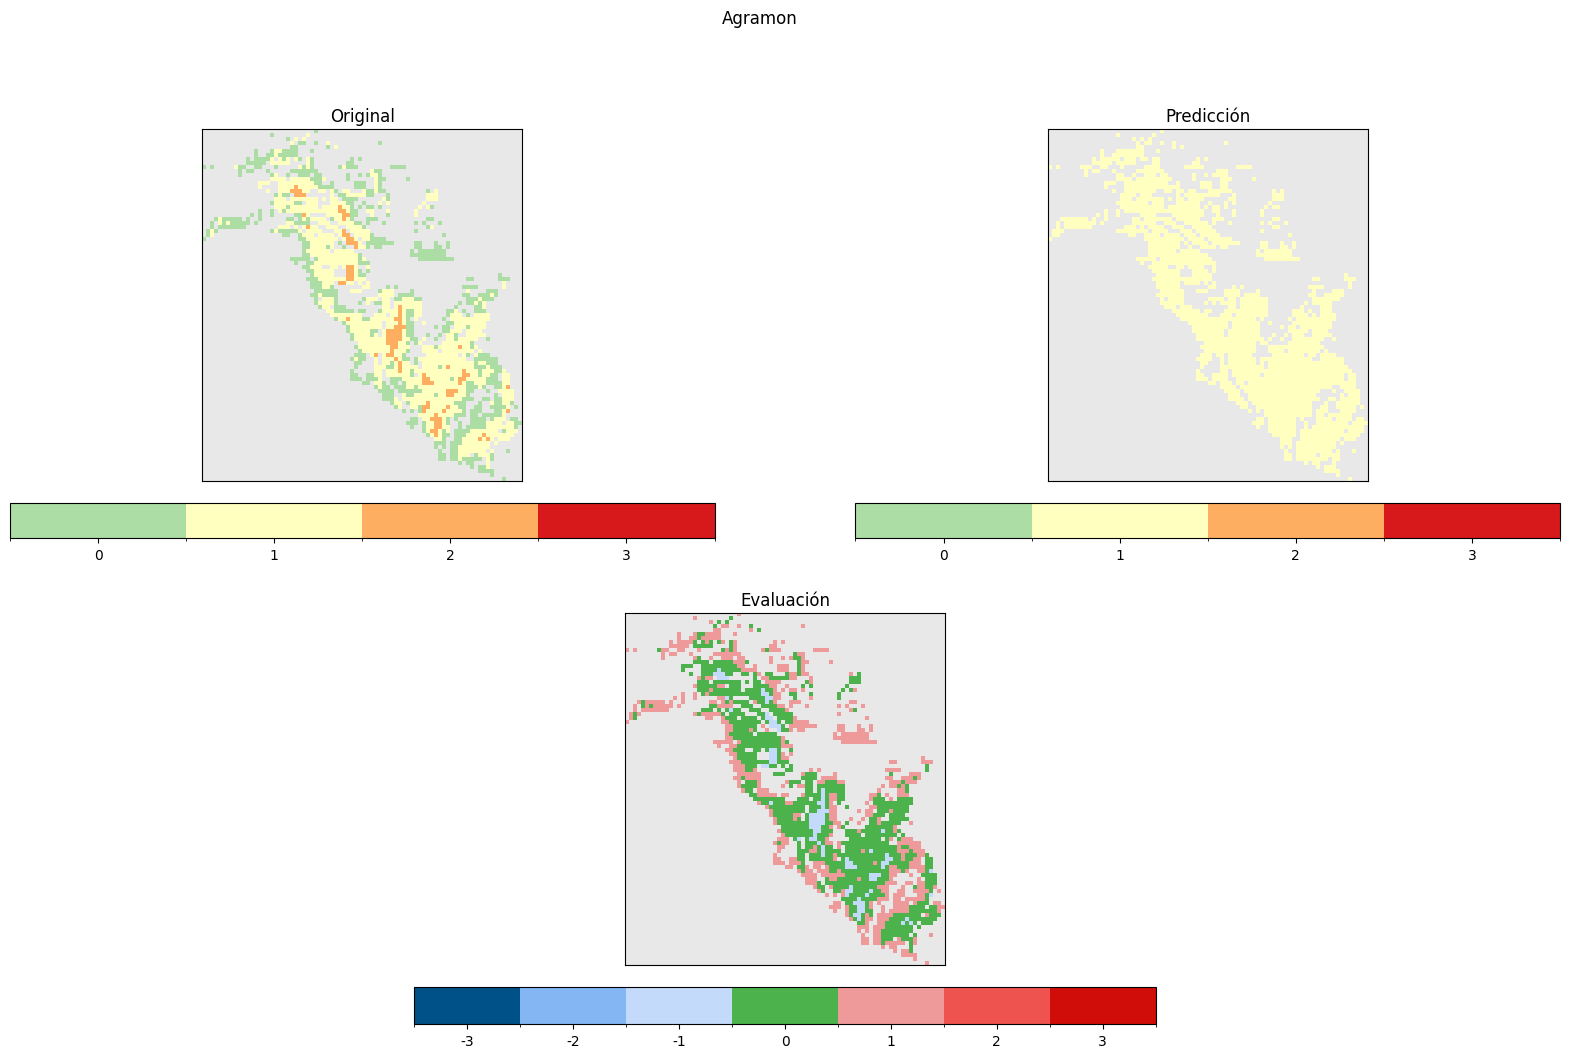

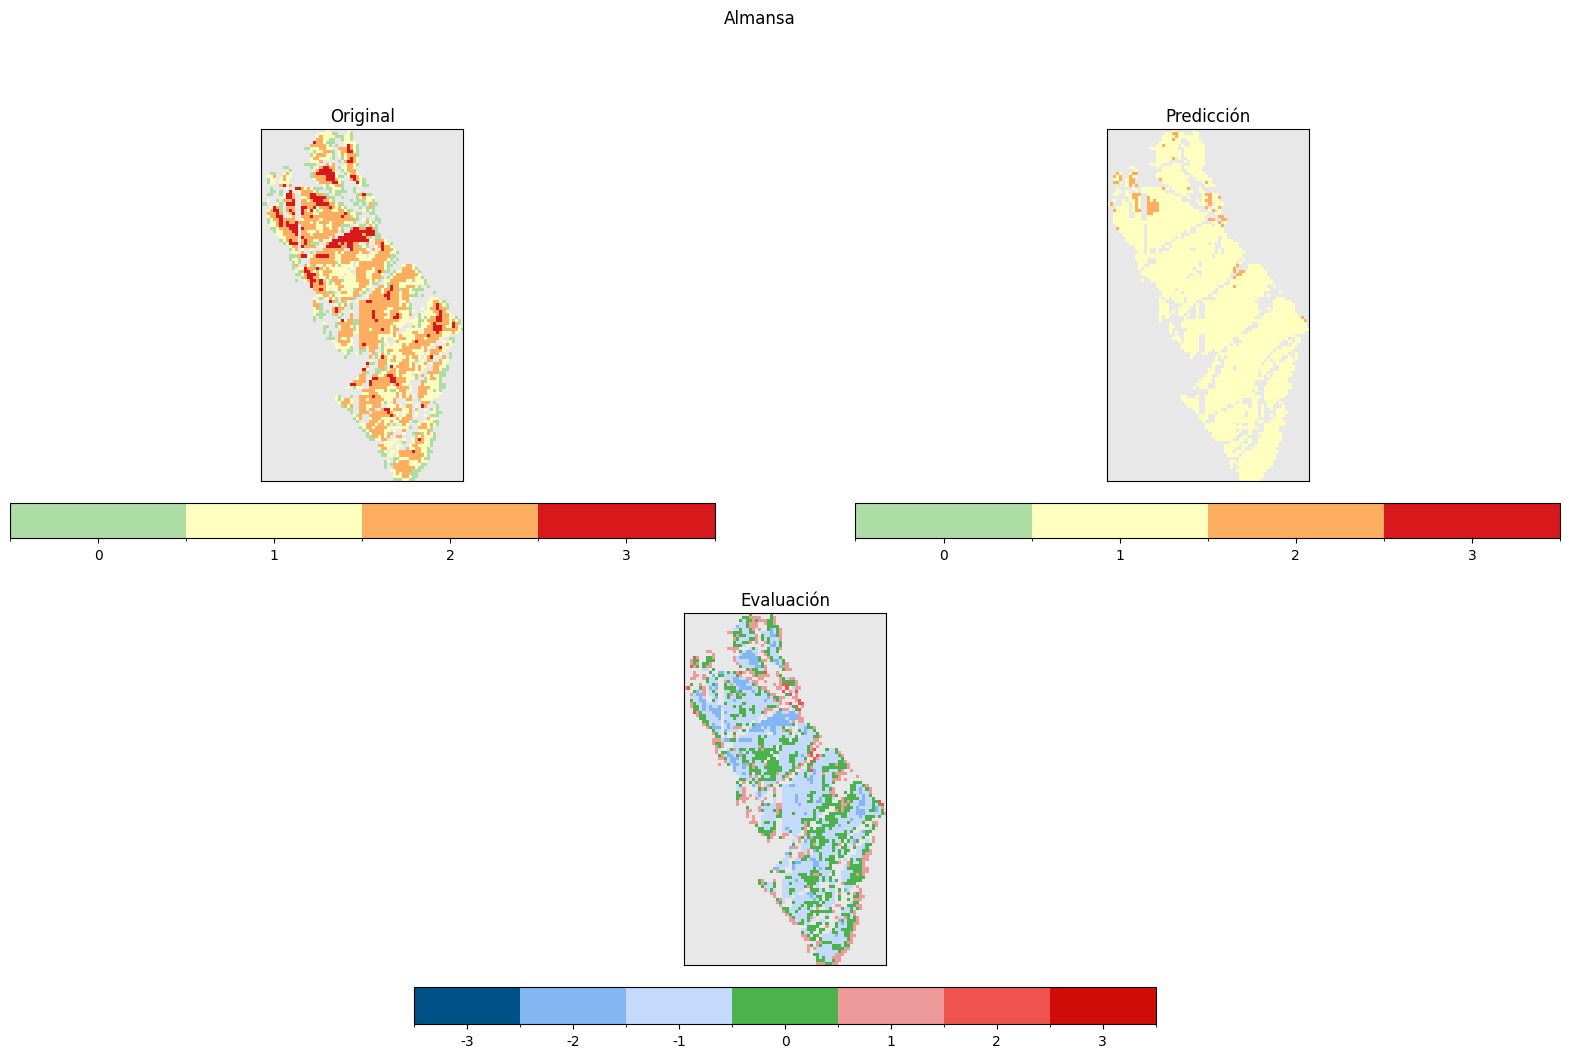

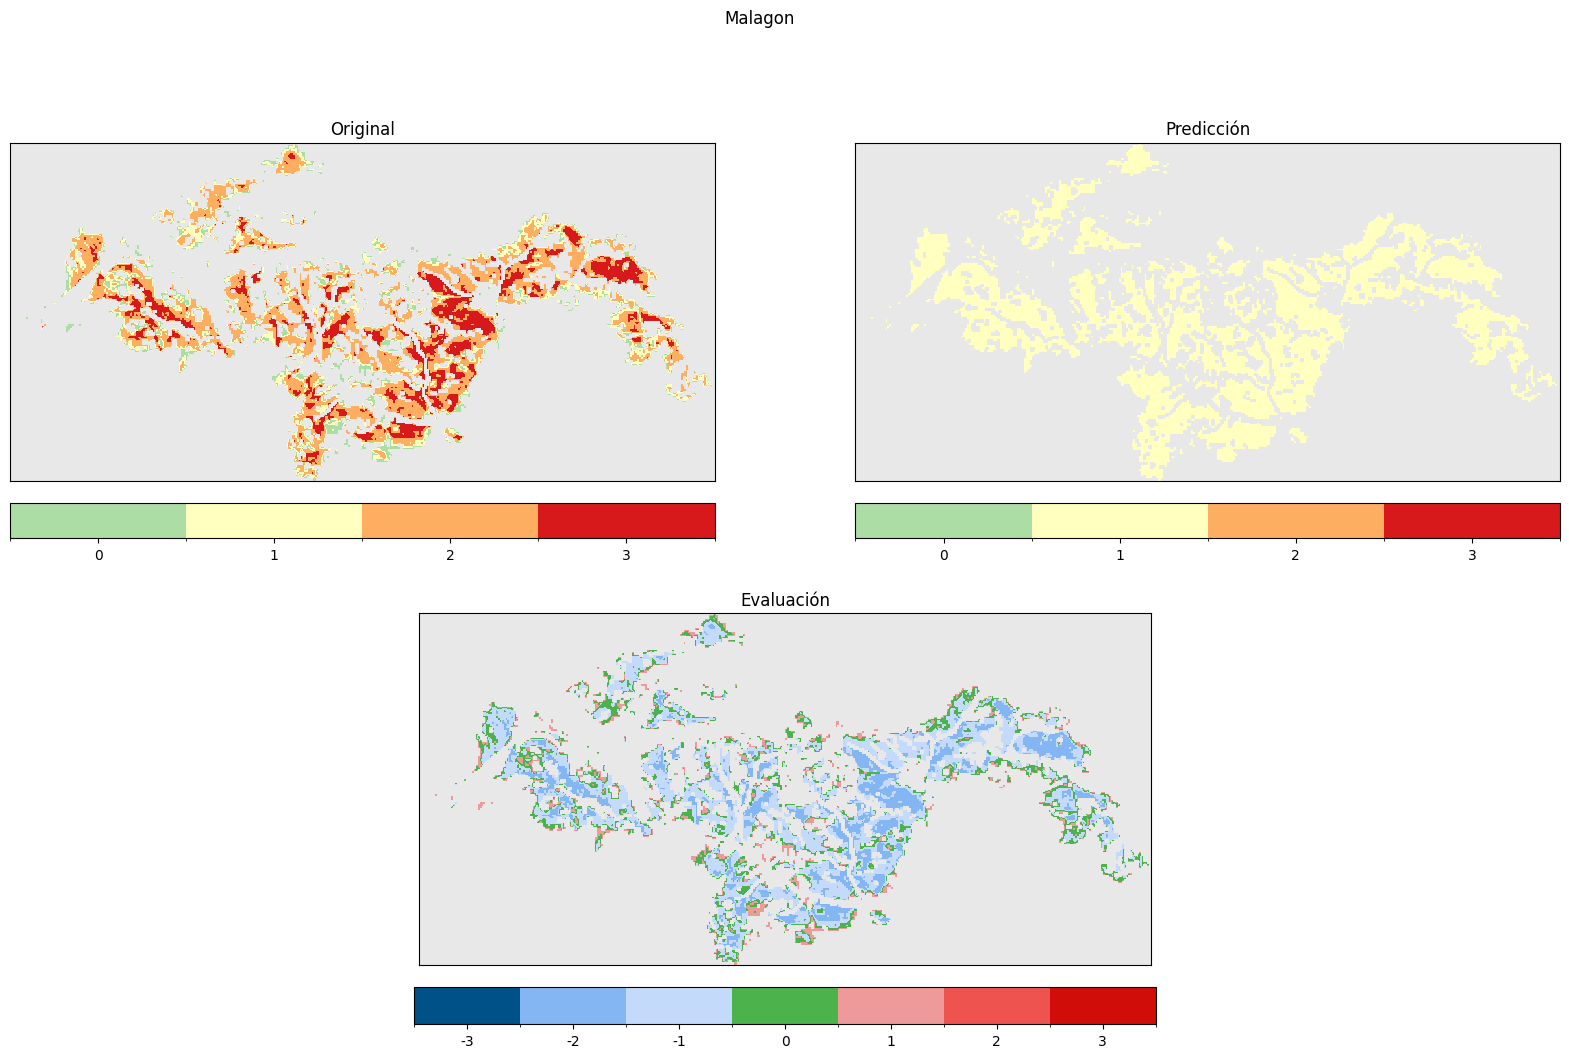

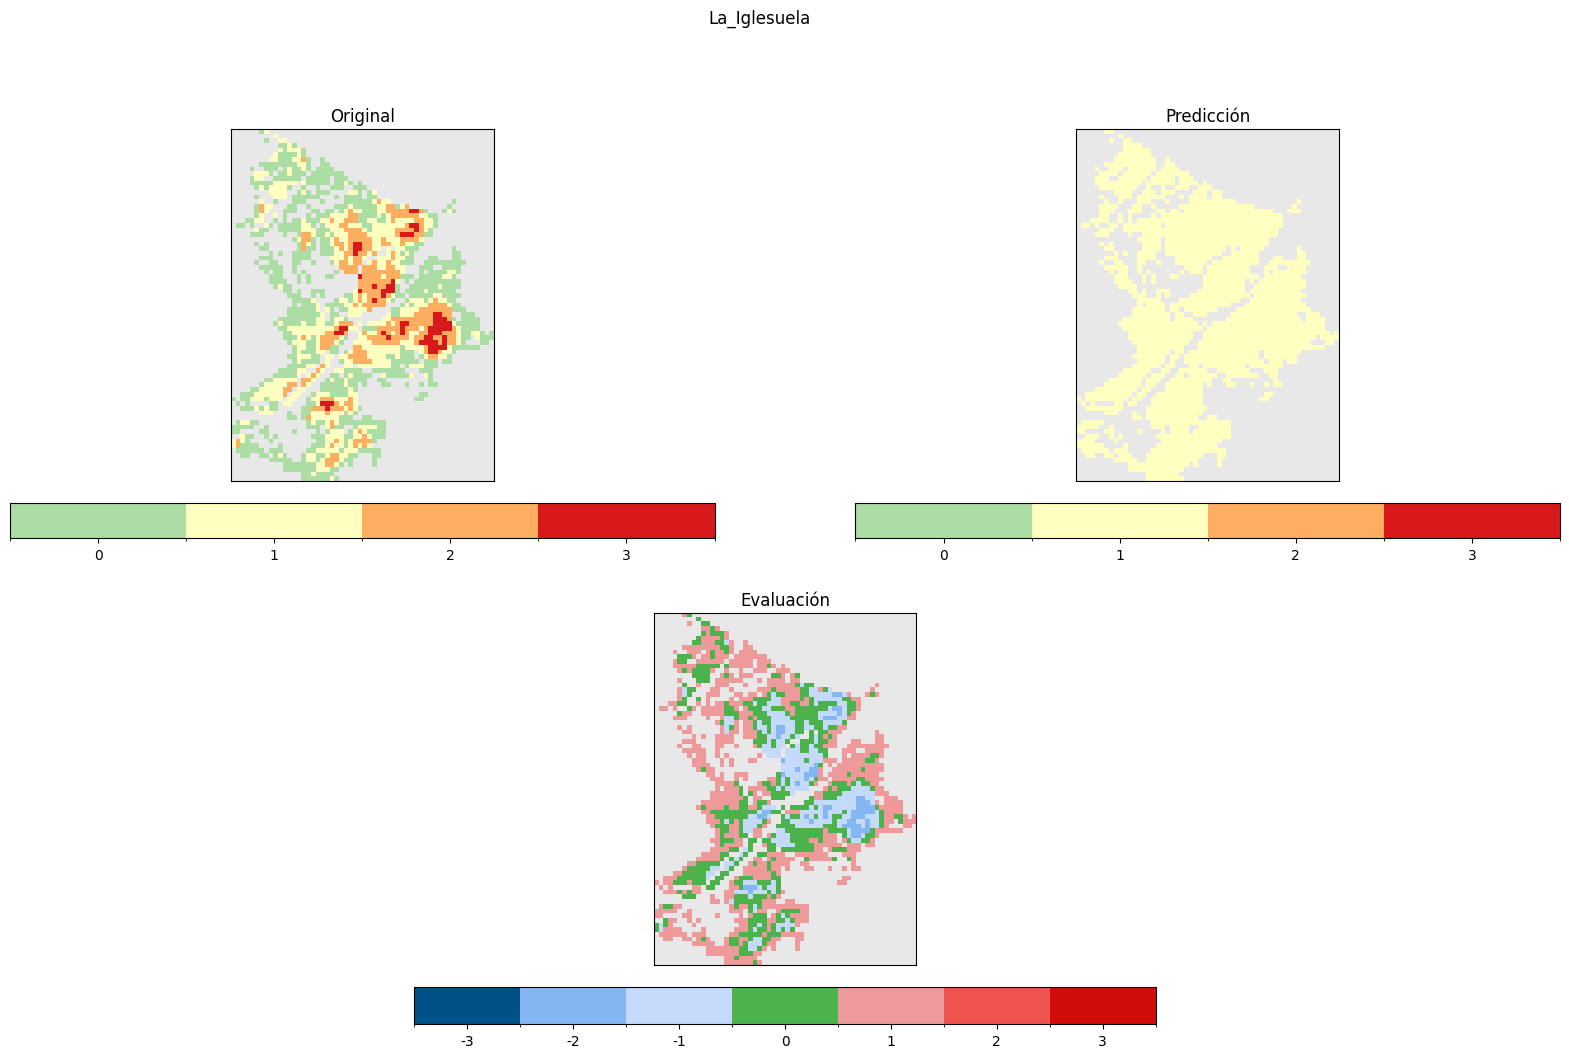

In [24]:
for fire_name in test_fire_names:
    df_fire = df_test[df_test['incendio'] == fire_name]

    X_fire = df_fire[variables]
    y_fire = df_fire[target_discrete]
    coords_fire = df_fire[coords_columns]

    pred_fire = model.predict(X_fire)
    pred_fire = discretize_severities(pred_fire)

    matrix_fire = sm.get_severity_matrix(y_fire, coords_fire)
    matrix_pred = sm.get_severity_matrix(pred_fire, coords_fire)
    sm.show_original_prediction_evaluation_severity_matrices(matrix_fire, matrix_pred, fig_title=fire_name)

# Clasificación

In [25]:
X_train = df_train[variables]
y_train = df_train[target_discrete]

X_test = df_test[variables]
y_test = df_test[target_discrete]

## Grid Search

### Logistic Regression

In [26]:
poly = PolynomialFeatures(include_bias=False)
logistic_reg = LogisticRegression(random_state=seed)
logistic_reg_pipeline = make_pipeline(preprocessing, poly, logistic_reg)

param_grid = {
    'polynomialfeatures__degree': [1, 2],
    'logisticregression__C': [0.01, 0.1, 1, 2, 5, 10],
    'logisticregression__max_iter': [100, 200]
}

logistic_reg_gs = optimize_params(logistic_reg_pipeline, X_train, y_train, folds, scoring='f1_weighted', **param_grid)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Time: 403.19 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__max_iter,param_polynomialfeatures__degree,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
2,4.756110,0.602313,0.032835,0.023026,0.01,200,1,"{'logisticregression__C': 0.01, 'logisticregre...",0.332049,0.315193,0.125181,1,0.412595,0.412520,0.011938
0,3.801292,0.398769,0.037107,0.022278,0.01,100,1,"{'logisticregression__C': 0.01, 'logisticregre...",0.331978,0.315110,0.125303,2,0.412602,0.412526,0.011938
4,4.211520,0.434273,0.033069,0.022346,0.1,100,1,"{'logisticregression__C': 0.1, 'logisticregres...",0.325106,0.310612,0.124447,3,0.414134,0.414088,0.011660
6,7.740455,0.802827,0.032529,0.020848,0.1,200,1,"{'logisticregression__C': 0.1, 'logisticregres...",0.324111,0.310422,0.123898,4,0.414128,0.414082,0.011640
10,6.791993,1.050464,0.034088,0.019039,1,200,1,"{'logisticregression__C': 1, 'logisticregressi...",0.321996,0.308981,0.123928,5,0.414314,0.414271,0.011564
8,4.195123,0.452269,0.032718,0.021235,1,100,1,"{'logisticregression__C': 1, 'logisticregressi...",0.321939,0.309003,0.123918,6,0.414314,0.414268,0.011595
14,6.094578,1.245163,0.030968,0.019558,2,200,1,"{'logisticregression__C': 2, 'logisticregressi...",0.321824,0.309016,0.123779,7,0.414325,0.414281,0.011592
22,6.019646,1.240301,0.032097,0.023173,10,200,1,"{'logisticregression__C': 10, 'logisticregress...",0.321771,0.308940,0.123856,8,0.414341,0.414298,0.011572
18,6.036322,1.333527,0.034339,0.021980,5,200,1,"{'logisticregression__C': 5, 'logisticregressi...",0.321742,0.308951,0.123815,9,0.414335,0.414291,0.011588
12,4.238266,0.447367,0.033171,0.023911,2,100,1,"{'logisticregression__C': 2, 'logisticregressi...",0.321242,0.308577,0.123962,10,0.414321,0.414278,0.011597


### KNeighbors

In [27]:
k_neighbors_class = KNeighborsClassifier()
k_neighbours_class_pipeline = make_pipeline(preprocessing, k_neighbors_class)

param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 20, 50, 100],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

k_neighbors_class_gs = optimize_params(k_neighbours_class_pipeline, X_train, y_train, folds, scoring='f1_weighted', **param_grid)

Fitting 11 folds for each of 10 candidates, totalling 110 fits
Time: 1795.35 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
5,0.110949,0.015211,12.762092,10.642924,20,distance,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.349097,0.361159,0.081529,1,1.000000,1.000000,0.000000
3,0.108255,0.018291,12.991047,10.851326,10,distance,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.348762,0.362792,0.086398,2,1.000000,1.000000,0.000000
7,0.108451,0.014053,13.464646,11.289879,50,distance,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.347890,0.363606,0.080095,3,1.000000,1.000000,0.000000
1,0.107309,0.017344,12.858574,10.717307,5,distance,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.347373,0.361529,0.088441,4,1.000000,1.000000,0.000000
6,0.109541,0.015828,13.426098,11.246112,50,uniform,"{'kneighborsclassifier__n_neighbors': 50, 'kne...",0.346276,0.362347,0.080686,5,0.549028,0.548840,0.005864
4,0.110487,0.018814,12.853102,10.886783,20,uniform,"{'kneighborsclassifier__n_neighbors': 20, 'kne...",0.345553,0.358192,0.084381,6,0.582418,0.582382,0.005025
2,0.110716,0.015523,12.970678,10.856696,10,uniform,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.343106,0.357421,0.092789,7,0.615428,0.615442,0.004040
9,0.116247,0.014353,14.167944,11.995497,100,distance,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.341687,0.356188,0.080952,8,1.000000,1.000000,0.000000
8,0.112882,0.014308,13.992989,11.751921,100,uniform,"{'kneighborsclassifier__n_neighbors': 100, 'kn...",0.340910,0.355638,0.081772,9,0.529873,0.529628,0.006681
0,0.145013,0.020122,13.182764,10.869111,5,uniform,"{'kneighborsclassifier__n_neighbors': 5, 'knei...",0.337173,0.353592,0.095186,10,0.661336,0.661375,0.003530


### Decision Tree

In [28]:
decision_tree_class = DecisionTreeClassifier(random_state=seed)
decision_tree_class_pipeline = make_pipeline(preprocessing, decision_tree_class)

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 7, 10, None],
    'decisiontreeclassifier__min_samples_split': [2, 50, 200],
    'decisiontreeclassifier__criterion': ['entropy', 'gini'],
    'decisiontreeclassifier__ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.1]
}

decision_tree_class_gs = optimize_params(decision_tree_class_pipeline, X_train, y_train, folds, scoring='f1_weighted', **param_grid)

Fitting 11 folds for each of 150 candidates, totalling 1650 fits
Time: 724.31 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__ccp_alpha,param_decisiontreeclassifier__criterion,param_decisiontreeclassifier__max_depth,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
9,5.704460,0.586086,0.017733,0.011611,0,entropy,10,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.319102,0.338531,0.094017,1,0.576840,0.577236,0.005527
12,9.723671,0.989217,0.017377,0.012023,0,entropy,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.318908,0.316612,0.072917,2,1.000000,1.000000,0.000000
28,6.359521,0.687887,0.016937,0.008503,0,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.311470,0.319695,0.116911,3,0.728665,0.728695,0.002925
27,7.403948,0.803671,0.016903,0.009324,0,gini,None,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.309734,0.314799,0.111554,4,1.000000,1.000000,0.000000
10,5.662584,0.602837,0.017186,0.011177,0,entropy,10,"{'decisiontreeclassifier__ccp_alpha': 0, 'deci...",0.309470,0.324959,0.090762,5,0.573231,0.573558,0.005214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,3.009686,0.277564,0.017298,0.009548,0.1,entropy,5,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.238451,0.262961,0.125785,146,0.229423,0.229519,0.014608
122,1.859376,0.189208,0.018264,0.010438,0.1,entropy,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.238451,0.262961,0.125785,147,0.229423,0.229519,0.014608
121,1.863536,0.179981,0.017348,0.007381,0.1,entropy,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.238451,0.262961,0.125785,148,0.229423,0.229519,0.014608
120,1.818677,0.199212,0.017464,0.011291,0.1,entropy,3,"{'decisiontreeclassifier__ccp_alpha': 0.1, 'de...",0.238451,0.262961,0.125785,149,0.229423,0.229519,0.014608


### Random Forest

In [29]:
random_forest_class = RandomForestClassifier(random_state=seed)
random_forest_class_pipeline = make_pipeline(preprocessing, random_forest_class)

param_grid = {
    'randomforestclassifier__n_estimators': [10, 25, 50],
    'randomforestclassifier__max_depth': [3, 5, 7, None],
    'randomforestclassifier__criterion': ['entropy', 'gini'],
}

random_forest_class_gs = optimize_params(random_forest_class_pipeline, X_train, y_train, folds, scoring='f1_weighted', **param_grid)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Time: 532.75 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__criterion,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
19,13.036270,1.341905,0.054688,0.047104,gini,7,25,"{'randomforestclassifier__criterion': 'gini', ...",0.298066,0.314755,0.133445,1,0.507822,0.507808,0.009100
18,5.425664,0.586021,0.035320,0.029451,gini,7,10,"{'randomforestclassifier__criterion': 'gini', ...",0.282214,0.316284,0.127158,2,0.499475,0.499578,0.012205
16,9.603572,1.032057,0.056470,0.047098,gini,5,25,"{'randomforestclassifier__criterion': 'gini', ...",0.281171,0.294389,0.106244,3,0.439877,0.440006,0.010852
6,6.491856,0.573080,0.031898,0.024526,entropy,7,10,{'randomforestclassifier__criterion': 'entropy...,0.279989,0.304232,0.098730,4,0.500106,0.500351,0.007521
21,12.932831,1.387155,0.035353,0.025325,gini,None,10,"{'randomforestclassifier__criterion': 'gini', ...",0.277346,0.277173,0.083270,5,0.986946,0.986931,0.000246
3,4.839494,0.486343,0.029928,0.019404,entropy,5,10,{'randomforestclassifier__criterion': 'entropy...,0.277075,0.308546,0.131812,6,0.430532,0.430888,0.008271
4,11.749580,1.156126,0.047220,0.033816,entropy,5,25,{'randomforestclassifier__criterion': 'entropy...,0.273659,0.288349,0.110820,7,0.434856,0.434892,0.009666
20,24.148719,2.228845,0.078694,0.063110,gini,7,50,"{'randomforestclassifier__criterion': 'gini', ...",0.268373,0.300306,0.137871,8,0.509704,0.509664,0.008381
10,39.379736,4.380540,0.061149,0.052113,entropy,None,25,{'randomforestclassifier__criterion': 'entropy...,0.267127,0.293025,0.135563,9,0.998848,0.998848,0.000096
17,18.910050,1.971120,0.083694,0.075833,gini,5,50,"{'randomforestclassifier__criterion': 'gini', ...",0.266211,0.281800,0.108590,10,0.438215,0.438323,0.010052


### XGBoost

In [30]:
xgb_class = XGBClassifier(random_state=seed)
xgb_class_pipeline = make_pipeline(preprocessing, xgb_class)

param_grid = {
    'xgbclassifier__n_estimators': [10, 25, 50, 100],
    'xgbclassifier__max_depth': [3, 5, 7, 10, None],
    'xgbclassifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
}

xgb_class_gs = optimize_params(xgb_class_pipeline, X_train, y_train, folds, scoring='f1_weighted', **param_grid)

Fitting 11 folds for each of 120 candidates, totalling 1320 fits
Time: 1084.0 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
15,31.779493,1.944349,0.475993,0.433519,0.001,10,100,"{'xgbclassifier__learning_rate': 0.001, 'xgbcl...",0.330984,0.338235,0.122596,1,0.605744,0.606360,0.007825
33,7.815307,0.630286,0.111848,0.079667,0.005,10,25,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.329933,0.334177,0.129278,2,0.607027,0.607628,0.007620
52,3.453418,0.257259,0.066318,0.052124,0.01,10,10,"{'xgbclassifier__learning_rate': 0.01, 'xgbcla...",0.329774,0.335393,0.122127,3,0.605429,0.605998,0.007560
14,15.290515,1.036360,0.229862,0.188387,0.001,10,50,"{'xgbclassifier__learning_rate': 0.001, 'xgbcl...",0.327736,0.335609,0.123714,4,0.602601,0.603283,0.008256
13,7.846762,0.498771,0.123896,0.092318,0.001,10,25,"{'xgbclassifier__learning_rate': 0.001, 'xgbcl...",0.327615,0.335233,0.122787,5,0.600809,0.601479,0.008269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,26.964483,1.599553,0.495075,0.503356,0.05,10,100,"{'xgbclassifier__learning_rate': 0.05, 'xgbcla...",0.241891,0.269467,0.091041,116,0.725323,0.726347,0.011279
7,10.422806,1.049670,0.153357,0.136811,0.001,5,100,"{'xgbclassifier__learning_rate': 0.001, 'xgbcl...",0.229660,0.247719,0.133979,117,0.477403,0.477561,0.008885
44,1.563807,0.133009,0.043064,0.026560,0.01,5,10,"{'xgbclassifier__learning_rate': 0.01, 'xgbcla...",0.229594,0.247581,0.134055,118,0.477293,0.477384,0.009484
25,3.064439,0.338426,0.058968,0.043661,0.005,5,25,"{'xgbclassifier__learning_rate': 0.005, 'xgbcl...",0.229533,0.247281,0.134180,119,0.476781,0.476816,0.009464


### SGD

In [31]:
sgd_class = SGDClassifier(random_state=seed)
sgd_class_pipeline = make_pipeline(preprocessing, sgd_class)

param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.8],
    'sgdclassifier__max_iter': [50, 100, 500, 1000],
    'sgdclassifier__loss': ['log_loss', 'hinge', 'modified_huber']
}

sgd_class_gs = optimize_params(sgd_class_pipeline, X_train, y_train, folds, scoring='f1_weighted', **param_grid)

Fitting 11 folds for each of 84 candidates, totalling 924 fits
Time: 178.53 seg.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,param_sgdclassifier__loss,param_sgdclassifier__max_iter,params,weighted_mean_test_score,mean_test_score,std_test_score,rank_test_score,weighted_mean_train_score,mean_train_score,std_train_score
12,1.628687,0.183621,0.023473,0.012999,0.001,log_loss,50,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.316644,0.307045,0.125832,1,0.404202,0.404035,0.014979
15,1.614992,0.166232,0.022964,0.010718,0.001,log_loss,1000,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.316644,0.307045,0.125832,2,0.404202,0.404035,0.014979
14,1.609487,0.159934,0.023240,0.016689,0.001,log_loss,500,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.316644,0.307045,0.125832,3,0.404202,0.404035,0.014979
13,1.605935,0.176526,0.024102,0.014542,0.001,log_loss,100,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.316644,0.307045,0.125832,4,0.404202,0.404035,0.014979
8,6.226727,0.524349,0.023051,0.015386,0.0001,modified_huber,50,"{'sgdclassifier__alpha': 0.0001, 'sgdclassifie...",0.298028,0.309915,0.116699,5,0.392427,0.392443,0.018019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,1.712225,0.149594,0.022988,0.014170,0.001,hinge,50,"{'sgdclassifier__alpha': 0.001, 'sgdclassifier...",0.220640,0.248596,0.133867,80,0.354972,0.355754,0.020643
30,1.230687,0.119043,0.024241,0.013572,0.01,hinge,500,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.213064,0.256387,0.133379,81,0.353349,0.353109,0.012569
29,1.217631,0.119605,0.024547,0.011509,0.01,hinge,100,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.213064,0.256387,0.133379,82,0.353349,0.353109,0.012569
28,1.195778,0.129665,0.024300,0.015016,0.01,hinge,50,"{'sgdclassifier__alpha': 0.01, 'sgdclassifier_...",0.213064,0.256387,0.133379,83,0.353349,0.353109,0.012569


## Evaluación

In [32]:
class_dict = {
    'Regresion logistica': logistic_reg_gs,
    'KNeighbors' : k_neighbors_class_gs,
    'Arbol de decision': decision_tree_class_gs,
    'Random Forest': random_forest_class_gs,
    'XGBoost': xgb_class_gs,
    'SGD': sgd_class_gs
}


df_results_class = pd.DataFrame({
    'Modelo': class_dict.keys(),
    'Mejor puntuacion': [gs.best_score_ for gs in class_dict.values()]
})
df_results_class = df_results_class.sort_values(by='Mejor puntuacion', ascending=False)
df_results_class

,Modelo,Mejor puntuacion
1,KNeighbors,0.349097
0,Regresion logistica,0.332049
4,XGBoost,0.330984
2,Arbol de decision,0.319102
5,SGD,0.316644
3,Random Forest,0.298066


In [33]:
model = k_neighbors_class_gs.best_estimator_
model_path = os.path.join('models', 'experiment_2', 'model_class.joblib')
dump(model, model_path)

['models\\experiment_2\\model_class.joblib']

In [34]:
model_path = os.path.join('models', 'experiment_2', 'model_class.joblib')
model = load(model_path)
pred = model.predict(X_test)

print(f"""Métricas predicción del test
F1:        {f1_score(y_test, pred, average='weighted')}
Recall:    {recall_score(y_test, pred, average='weighted')}
Precision: {precision_score(y_test, pred, average='weighted')}
Accuracy:  {accuracy_score(y_test, pred)}""")

Métricas predicción del test
F1:        0.18446897966933362
Recall:    0.24258418231659915
Precision: 0.2617122772182663
Accuracy:  0.24258418231659915


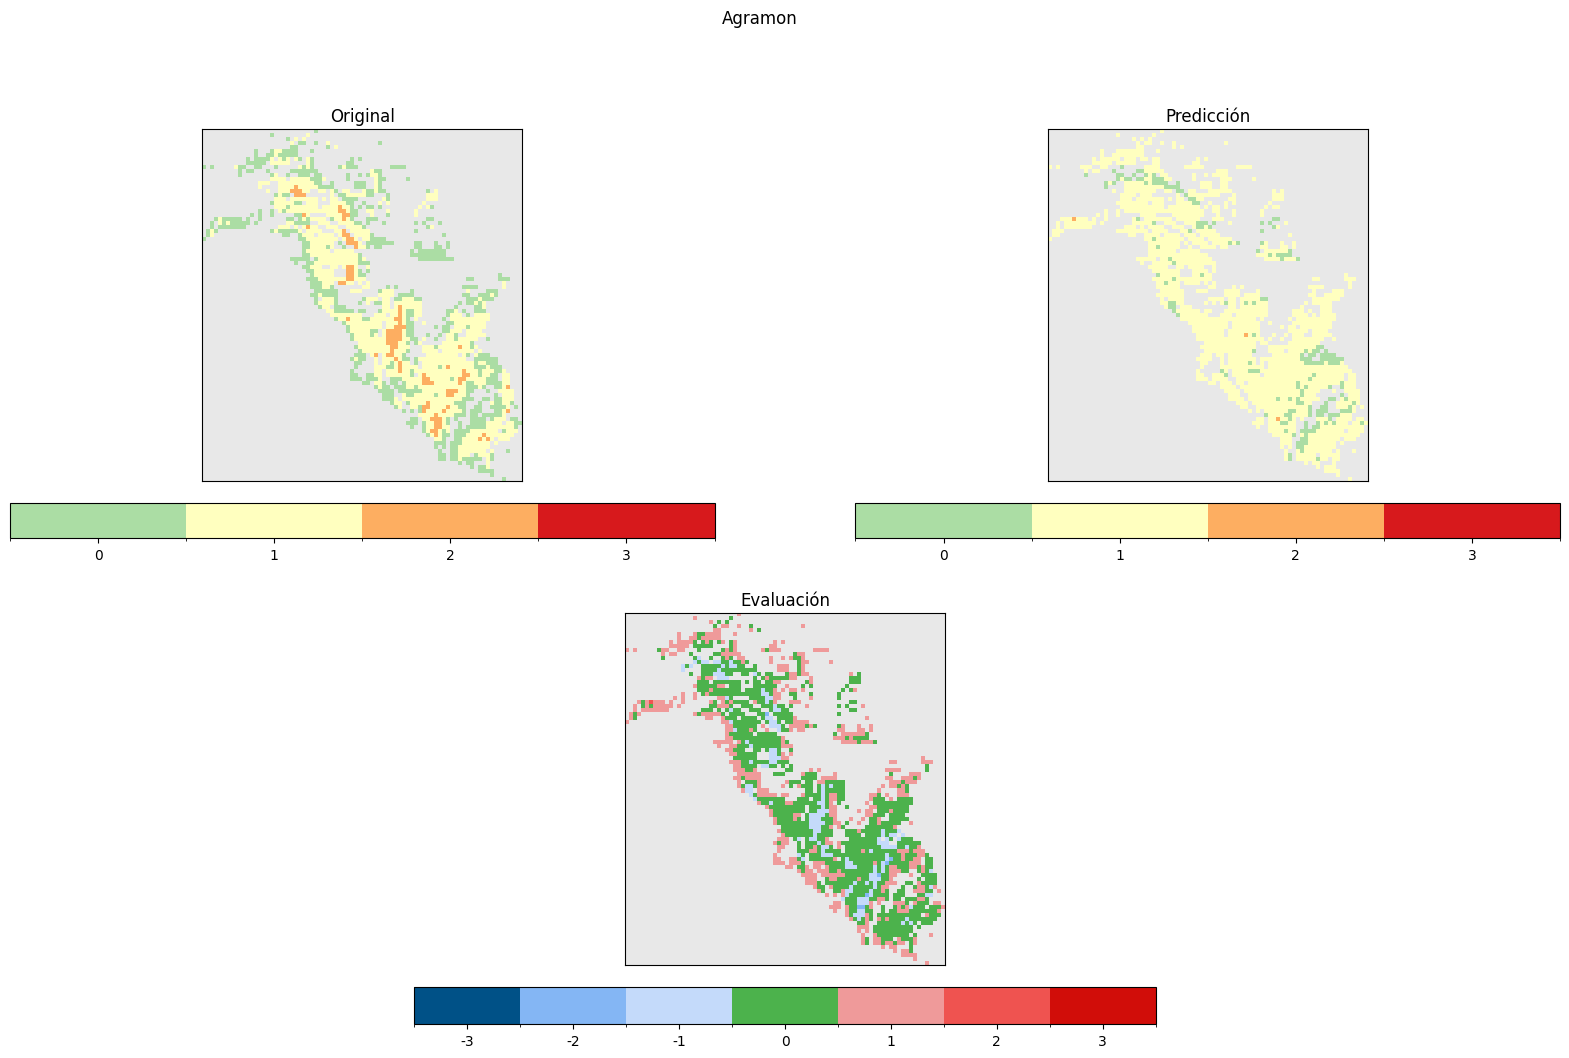

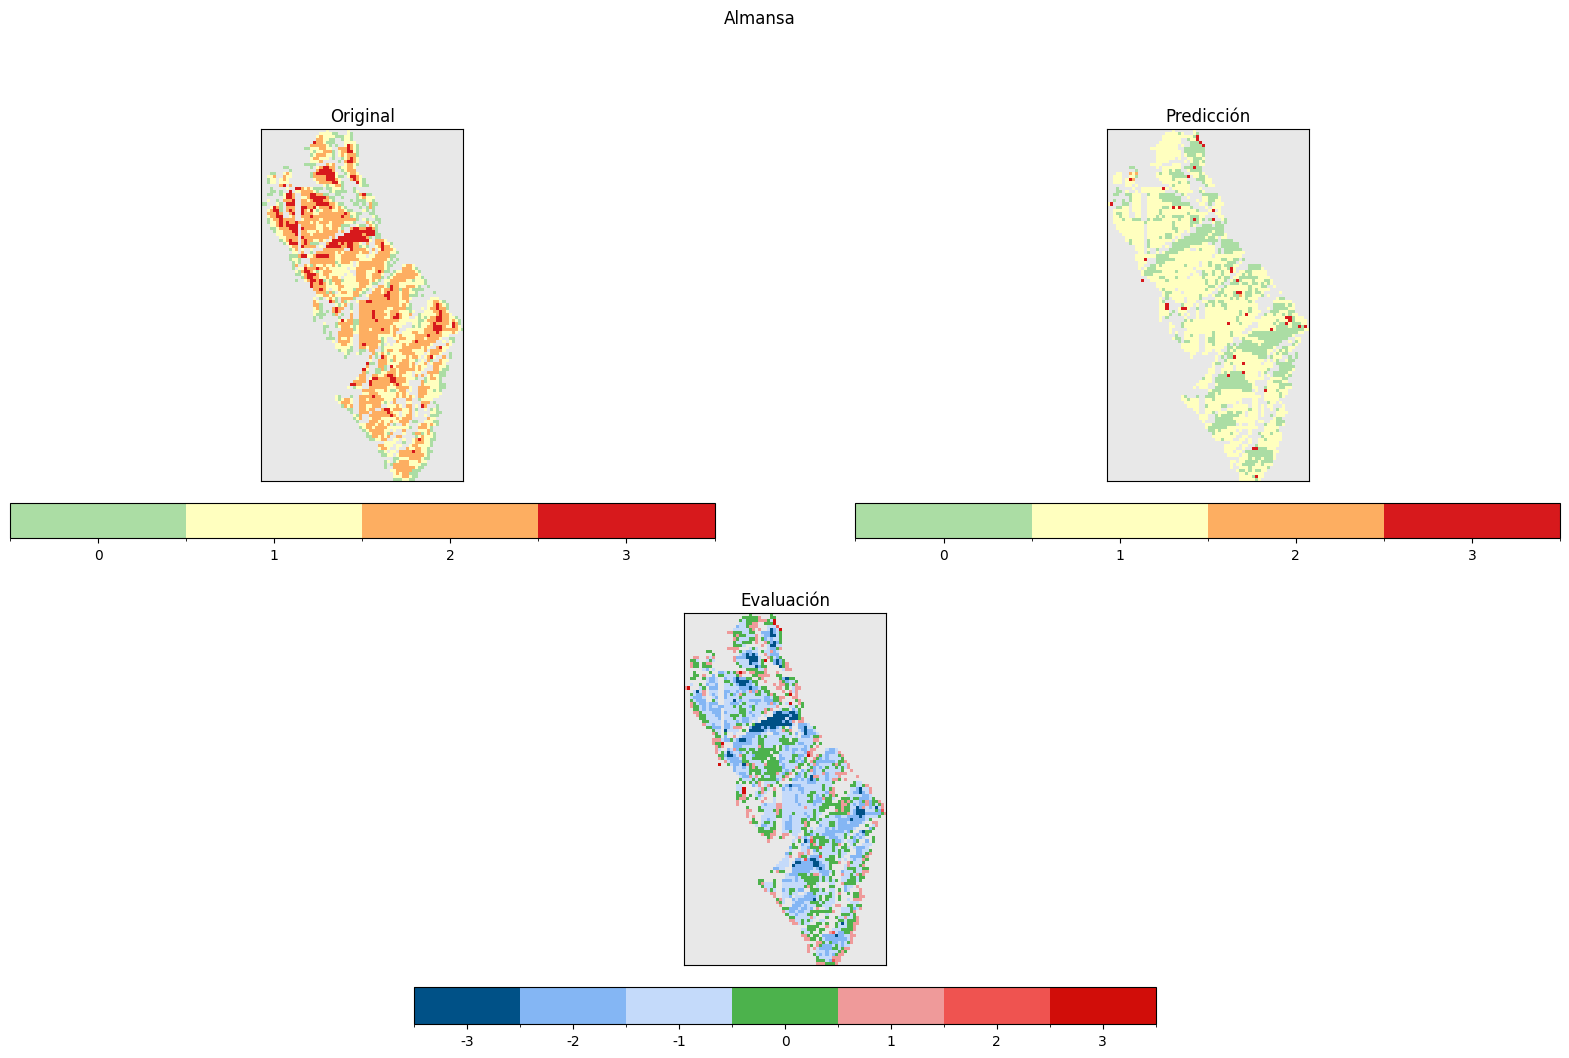

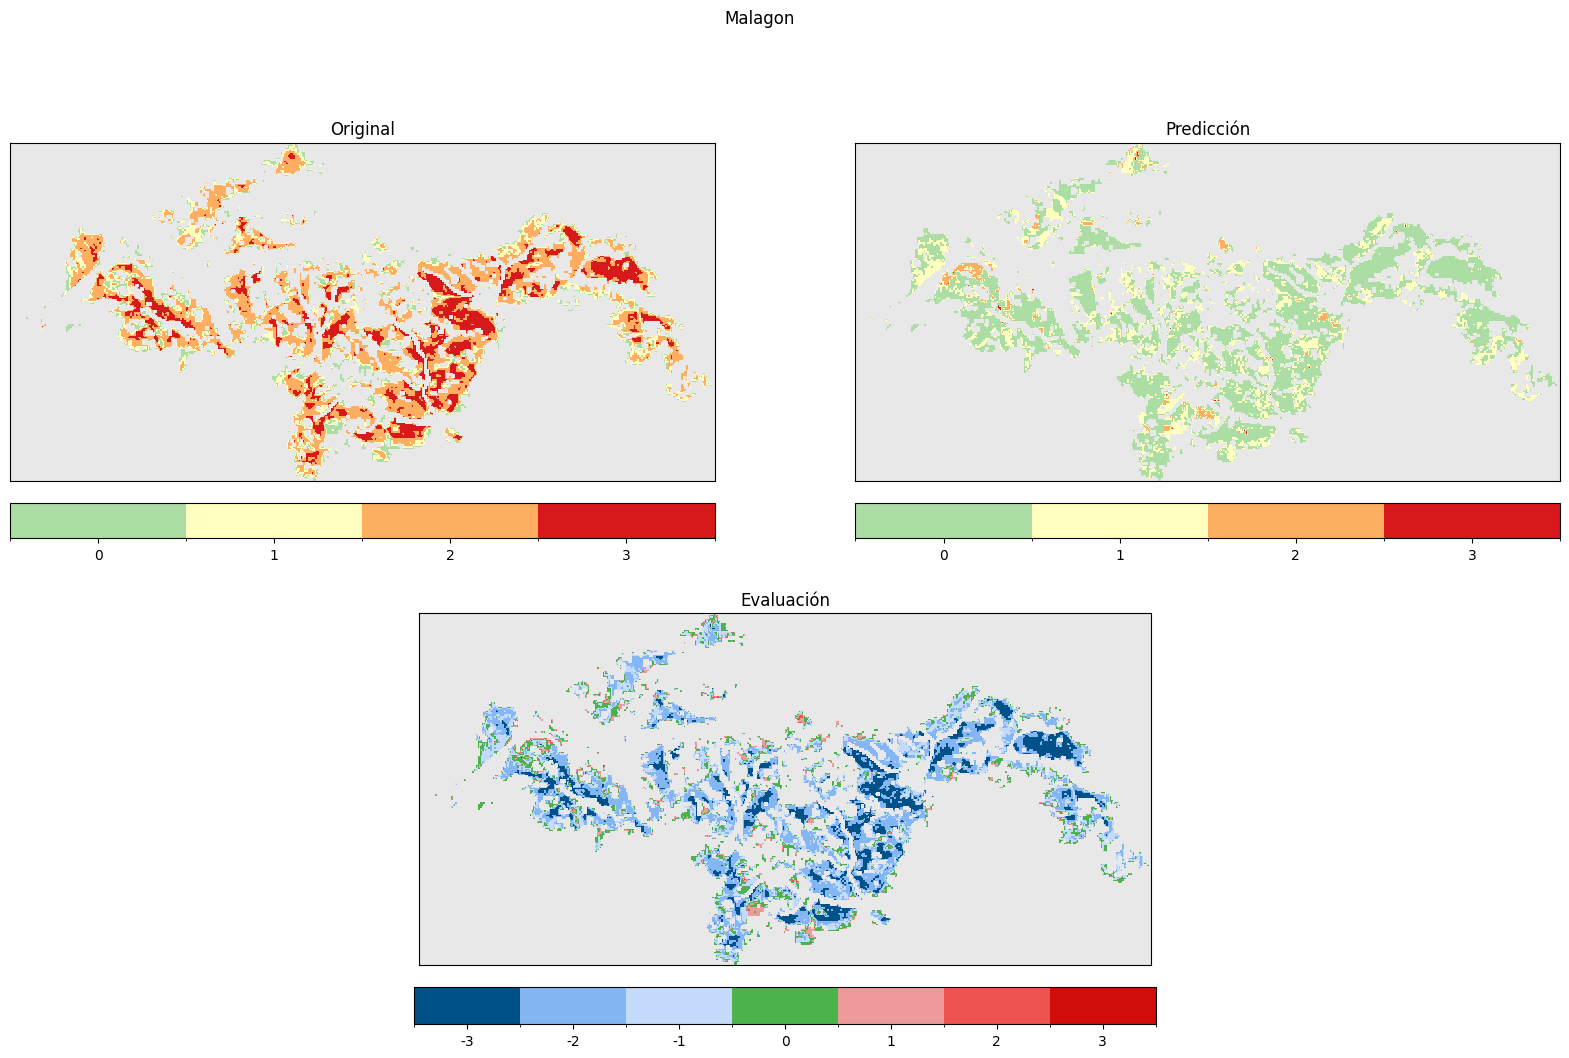

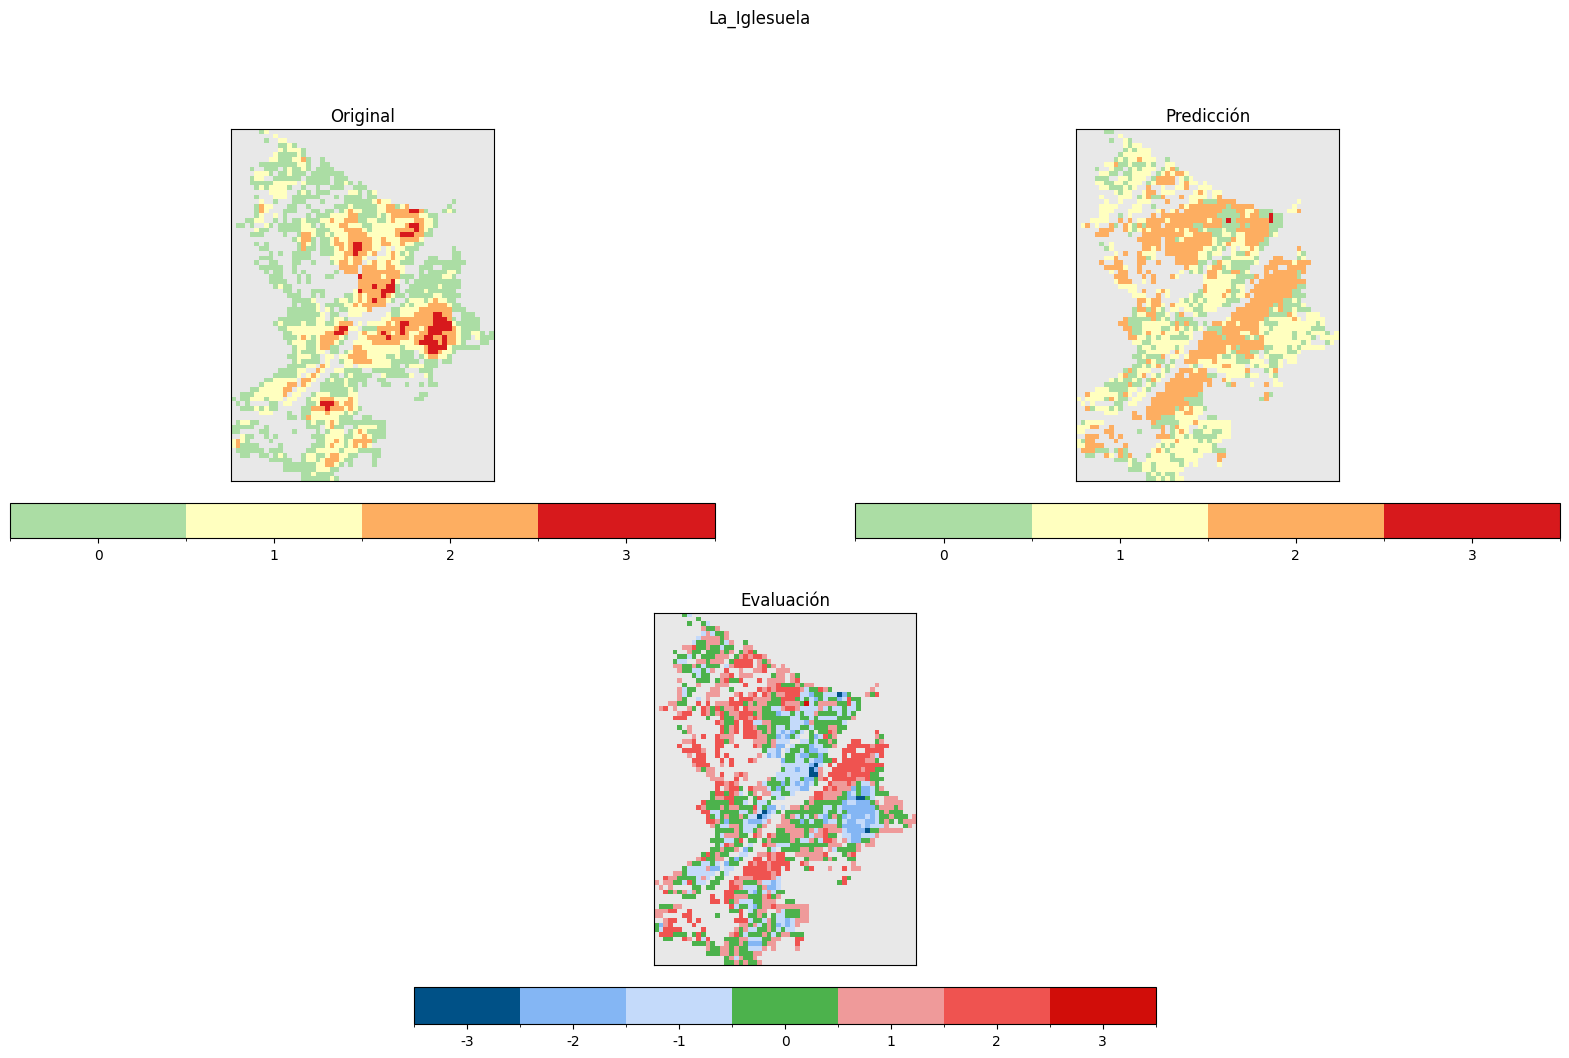

In [35]:
for fire_name in test_fire_names:
    df_fire = df_test[df_test['incendio'] == fire_name]

    X_fire = df_fire[variables]
    y_fire = df_fire[target_discrete]
    coords_fire = df_fire[coords_columns]

    pred_fire = model.predict(X_fire)

    matrix_fire = sm.get_severity_matrix(y_fire, coords_fire)
    matrix_pred = sm.get_severity_matrix(pred_fire, coords_fire)
    sm.show_original_prediction_evaluation_severity_matrices(matrix_fire, matrix_pred, fig_title=fire_name)